<img src="relation_network.jpg" style="width:600px;height:674px;float:middle">
以上為relation network的計算流程

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data # Import MNIST data
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets('MNIST_data' , one_hot = False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
aug = ImageDataGenerator(rotation_range = 25,
                          width_shift_range = 0.1,
                          height_shift_range = 0.1 ,
                          shear_range = 0.2 ,
                          zoom_range = 0.2,
                          fill_mode = 'nearest')

def get_train_batch(base_num = 2000 , batch_size = 50 , class_num = 10):
    image_set , label_set = mnist.train.next_batch(base_num)
    image_set = np.reshape(image_set , [-1 , 28 , 28 , 1])

#     # 可以減少overfitting的情況
#     augmentation_data = aug.flow(np.reshape(image_set , [-1 , 28 , 28 , 1]) ,
#                                  label_set ,
#                                  shuffle = True ,
#                                  batch_size = base_num)
#     image_set , label_set = augmentation_data[0][0] , augmentation_data[0][1]
    
    input_batch_size = int(batch_size / class_num)
    base_image_set = None
    input_image_set = None
    input_label_set = None
    for i in range(0 , class_num):
        # 從第i個class中的image隨機挑選出100張image成為base_image
        base_index = np.random.choice(np.where(label_set == i)[0] ,
                                      size = batch_size ,
                                      replace = False)

        # base_image → [50 , 1 , 28 , 28 , 1]
        base_image = np.reshape(image_set[base_index] , [batch_size , 1 , 28 , 28 , 1])
        if base_image_set is None:
            base_image_set = base_image
        else:
            # base_image_set → [50 , 10 , 28 , 28 , 1] (執行迴圈5次，沿著axis 1，將base_image堆疊10次)
            base_image_set = np.concatenate([base_image_set , base_image] , axis = 1)

        # 從剛才選中50組image以外的image，再從中隨機挑出5張image成為input_image
        rest_index = set(np.where(label_set == i)[0]).difference(set(base_index))
        rest_index = list(rest_index)
        input_index = np.random.choice(rest_index ,
                                       size = input_batch_size ,
                                       replace = False)
        # input_image → [5 , 28 , 28 , 1]
        input_image = np.reshape(image_set[input_index] , [input_batch_size , 28 , 28 , 1])
        if input_image_set is None:
            input_image_set = input_image
        else:
            # input_image_set → [50 , 28 , 28 , 1] (執行迴圈5次，沿著axis 0，將input_image堆疊10次)
            input_image_set = np.concatenate([input_image_set , input_image] , axis = 0)

        # input_label → [5 , 10]
        # 手寫數字為0的input_label[: , 0] = 1
        # 手寫數字為1的input_label[: , 1] = 1
        #                   ...
        # 手寫數字為9的input_label[: , 9] = 1
        input_label = np.zeros([input_batch_size , class_num])
        input_label[: , i] = 1
        if input_label_set is None:
            input_label_set = input_label
        else:
            # input_label_set → [50 , 10] (執行迴圈10次，沿著axis 0，將input_label堆疊5次)
            input_label_set = np.concatenate([input_label_set , input_label] , axis = 0)

    return base_image_set , input_image_set , input_label_set

In [4]:
def get_test_batch(data_num = 8000 , class_num = 10):
    image_set , label_set = mnist.train.next_batch(data_num)
    image_set_test = np.reshape(image_set , [-1 , 28 , 28 , 1])
    label_set_test = label_set
    return image_set_test , label_set_test

In [5]:
class_num = 10

input_image = tf.placeholder(tf.float32 , [None , 28 , 28 , 1])
base_image = tf.placeholder(tf.float32 , [None , class_num , 28 , 28 , 1])
base_image_0 = base_image[: , 0 , : , : , :]
base_image_1 = base_image[: , 1 , : , : , :]
base_image_2 = base_image[: , 2 , : , : , :]
base_image_3 = base_image[: , 3 , : , : , :]
base_image_4 = base_image[: , 4 , : , : , :]
base_image_5 = base_image[: , 5 , : , : , :]
base_image_6 = base_image[: , 6 , : , : , :]
base_image_7 = base_image[: , 7 , : , : , :]
base_image_8 = base_image[: , 8 , : , : , :]
base_image_9 = base_image[: , 9 , : , : , :]
y_true = tf.placeholder(tf.float32 , [None , class_num])
keep_prob = tf.placeholder(tf.float32)

In [6]:
def add_layer(inputs , in_size , out_size , activaction_function = None , dropout = True , reuse = False):
    # initializer = tf.glorot_uniform_initializer()
    initializer = tf.contrib.layers.xavier_initializer()
    Weights = tf.get_variable(initializer = initializer([in_size , out_size]) , name = 'w_a')
    biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.00001 , name = 'b_a')
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)
    if dropout:
        Wx_plus_b = tf.nn.dropout(Wx_plus_b , keep_prob)

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b , name = 'output')
        
    return outputs

In [7]:
def feature_extractor(input_ , reuse = False):
    with tf.variable_scope('conv1'):
        if reuse : tf.get_variable_scope().reuse_variables()
        conv_output_1 = tf.contrib.layers.conv2d(input_ , 32 , [7 , 7] ,
                                                 activation_fn = tf.nn.relu , padding='SAME' ,
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_1 = tf.contrib.layers.max_pool2d(conv_output_1 , [2, 2] , padding = 'SAME')

    with tf.variable_scope('conv2'):
        if reuse : tf.get_variable_scope().reuse_variables()
        conv_output_2 = tf.contrib.layers.conv2d(conv_pooling_1  , 64 , [5 , 5] ,
                                                 activation_fn = tf.nn.relu , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_2 = tf.contrib.layers.max_pool2d(conv_output_2 , [2, 2] , padding = 'SAME')

    with tf.variable_scope('conv3'):
        if reuse : tf.get_variable_scope().reuse_variables()
        conv_output_3 = tf.contrib.layers.conv2d(conv_pooling_2 , 128 , [3 , 3] ,
                                                 activation_fn = tf.nn.relu, padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_3 = tf.contrib.layers.max_pool2d(conv_output_3 , [2 , 2], padding = 'SAME')

    with tf.variable_scope('conv4'):
        if reuse : tf.get_variable_scope().reuse_variables()
        conv_output_4 = tf.contrib.layers.conv2d(conv_pooling_3 , 256, [1 , 1],
                                                 activation_fn = tf.nn.relu , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_4 = tf.contrib.layers.max_pool2d(conv_output_4 , [2 , 2] , padding = 'SAME')

    with tf.variable_scope('conv5') :
        if reuse : tf.get_variable_scope().reuse_variables()
        conv_output_5 = tf.contrib.layers.conv2d(conv_pooling_4 , 2, [1 , 1],
                                                 activation_fn = None , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_5 = tf.contrib.layers.max_pool2d(conv_output_5 , [2 , 2] , padding = 'SAME')

    with tf.variable_scope('flatten'):
        output_flatten = tf.contrib.layers.flatten(conv_pooling_5)

    return output_flatten

In [8]:
with tf.name_scope('feature_extractor'):
    embedding_input = feature_extractor(input_image , reuse = False)
    embedding_0 = feature_extractor(base_image_0 , reuse = True)
    embedding_1 = feature_extractor(base_image_1 , reuse = True)
    embedding_2 = feature_extractor(base_image_2 , reuse = True)
    embedding_3 = feature_extractor(base_image_3 , reuse = True)
    embedding_4 = feature_extractor(base_image_4 , reuse = True)
    embedding_5 = feature_extractor(base_image_5 , reuse = True)
    embedding_6 = feature_extractor(base_image_6 , reuse = True)
    embedding_7 = feature_extractor(base_image_7 , reuse = True)
    embedding_8 = feature_extractor(base_image_8 , reuse = True)
    embedding_9 = feature_extractor(base_image_9 , reuse = True)

with tf.variable_scope('relation_network'):
    embedding_concat_0 = tf.concat([embedding_0 , embedding_input] , axis = 1)
    embedding_concat_1 = tf.concat([embedding_1 , embedding_input] , axis = 1)
    embedding_concat_2 = tf.concat([embedding_2 , embedding_input] , axis = 1)
    embedding_concat_3 = tf.concat([embedding_3 , embedding_input] , axis = 1)
    embedding_concat_4 = tf.concat([embedding_4 , embedding_input] , axis = 1)
    embedding_concat_5 = tf.concat([embedding_5 , embedding_input] , axis = 1)
    embedding_concat_6 = tf.concat([embedding_6 , embedding_input] , axis = 1)
    embedding_concat_7 = tf.concat([embedding_7 , embedding_input] , axis = 1)
    embedding_concat_8 = tf.concat([embedding_8 , embedding_input] , axis = 1)
    embedding_concat_9 = tf.concat([embedding_9 , embedding_input] , axis = 1)
    embedding_concat = tf.concat([embedding_concat_0 , embedding_concat_1 , embedding_concat_2 , embedding_concat_3 , embedding_concat_4 ,
                                  embedding_concat_5 , embedding_concat_6 , embedding_concat_7 , embedding_concat_8 , embedding_concat_9] , axis = 1)


    # 刻意只做了3個簡單的變換，為的就是要逼出'feature_extractor'的潛能，可以抽出良好的embedding
    with tf.variable_scope('layer_1'):
        l1_c = add_layer(embedding_concat , 40 , class_num , activaction_function = None , dropout = None)
        
# the error between prediction and real data
with tf.variable_scope('cross_entropy'):
    relation_score = tf.nn.softmax(l1_c , axis = 1)
    relation_score  = tf.clip_by_value(relation_score  , 1e-8 , tf.reduce_max(relation_score))
    relation_score = tf.log(relation_score)
    cross_entropy_temp = -tf.reduce_sum(y_true * relation_score , axis = 1)
    cross_entropy = tf.reduce_mean(cross_entropy_temp)

with tf.variable_scope('optimizer'):  
    train_op = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

with tf.variable_scope('accuracy'):       
    correct = tf.equal(tf.argmax(relation_score , 1) , tf.argmax(y_true , 1))
    correct = tf.cast(correct, tf.float32)
    accuracy = tf.reduce_mean(correct)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

test_image , test_label = get_test_batch()
embedding_vector_list = []
for batch_i in range(0 , 3200):
    base_image_batch , input_image_batch , input_label_batch = get_train_batch()

    _ , train_loss , train_accuracy =\
    sess.run([train_op , cross_entropy , accuracy] , feed_dict = {input_image : input_image_batch ,
                                                                  y_true : input_label_batch ,
                                                                  base_image : base_image_batch})
    
    if batch_i % 50 == 0:
        print('=' * 30)
        print('batch_i : {}'.format(batch_i))
        print('training_loss : {:.4f}'.format(train_loss))
        print('training_accuracy : {:.2%}'.format(train_accuracy))
    
    if batch_i % 200 == 0:
        embedding_vector = sess.run(embedding_input , feed_dict = {input_image : test_image})
        embedding_vector_list.append(embedding_vector) 

batch_i : 0
training_loss : 2.3009
training_accuracy : 10.00%
batch_i : 50
training_loss : 1.7032
training_accuracy : 32.00%
batch_i : 100
training_loss : 1.1878
training_accuracy : 64.00%
batch_i : 150
training_loss : 0.9670
training_accuracy : 72.00%
batch_i : 200
training_loss : 0.8472
training_accuracy : 68.00%
batch_i : 250
training_loss : 0.9399
training_accuracy : 78.00%
batch_i : 300
training_loss : 0.4528
training_accuracy : 88.00%
batch_i : 350
training_loss : 0.3015
training_accuracy : 90.00%
batch_i : 400
training_loss : 0.5134
training_accuracy : 86.00%
batch_i : 450
training_loss : 0.4756
training_accuracy : 86.00%
batch_i : 500
training_loss : 0.4132
training_accuracy : 86.00%
batch_i : 550
training_loss : 0.2387
training_accuracy : 94.00%
batch_i : 600
training_loss : 0.2008
training_accuracy : 92.00%
batch_i : 650
training_loss : 0.3375
training_accuracy : 88.00%
batch_i : 700
training_loss : 0.4801
training_accuracy : 90.00%
batch_i : 750
training_loss : 0.0890
traini

可以發現隨著訓練的演進，每個手寫數字所屬的cluster會分得越來越遠

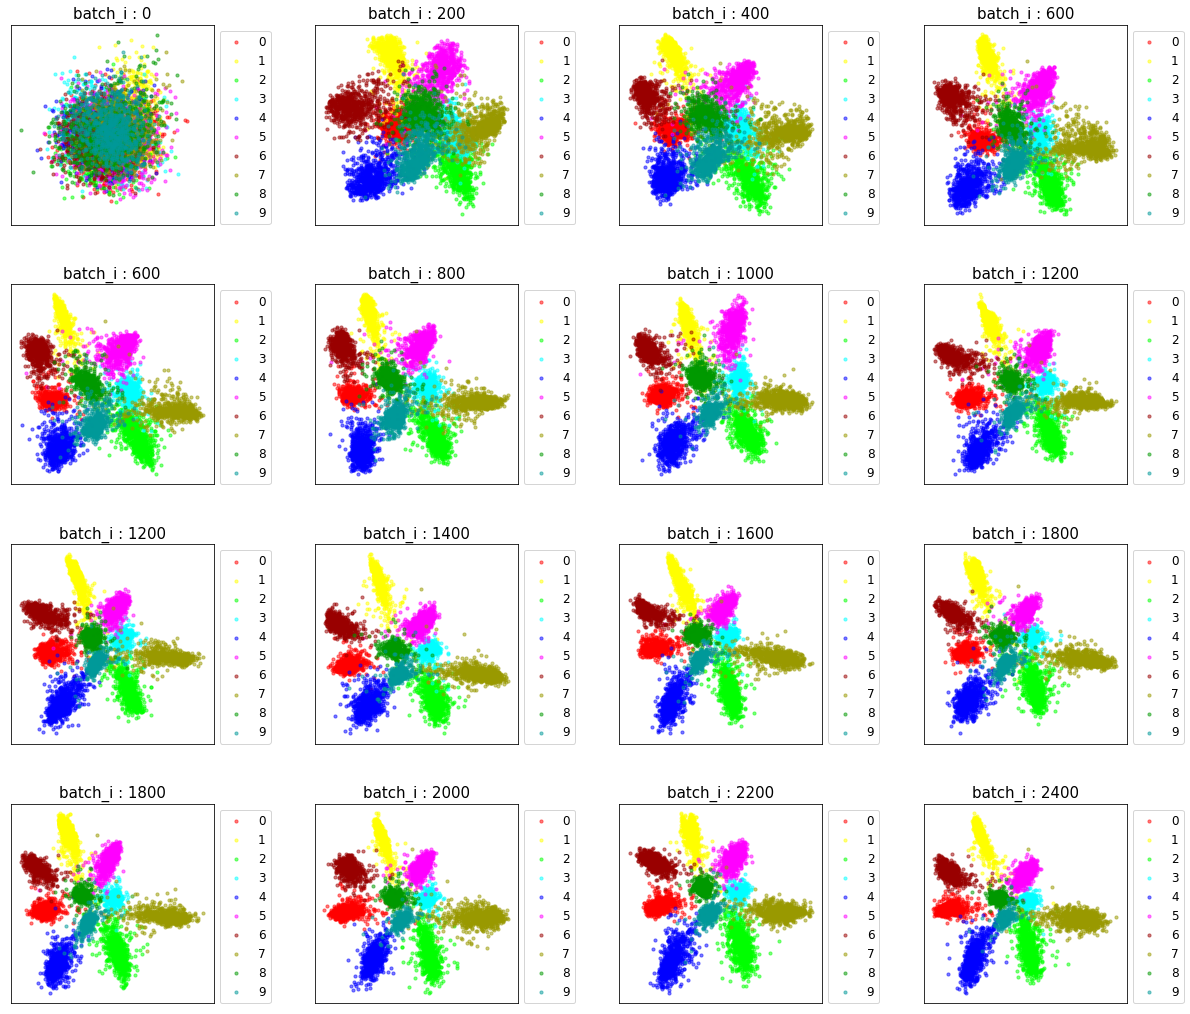

In [10]:
fig , ax = plt.subplots(4 , 4 , figsize = (20 , 18))
plt.subplots_adjust(wspace = 0.5 , hspace = 0.3)

colors_set = ['#ff0000' , '#ffff00' , '#00ff00' , '#00ffff' ,  '#0000ff' , 
              '#ff00ff' , '#990000' , '#999900' , '#009900' , '#009999']

for i in range(0 , 4):
    for j in range(0 , 4):
        embedding_vector = embedding_vector_list[4 * i + j]
        for class_ in range(0 , class_num):
            index = (test_label == class_)
            ax[i , j].scatter(embedding_vector[index , 0] , embedding_vector[index , 1] , 
                              alpha = 0.5 , s = 10 , c = colors_set[class_] , label = str(class_))
            ax[i , j].set_title('batch_i : {:1d}'.format((3 * i + j) * 200) , fontsize = 15) 
            ax[i , j].set_xticks([])
            ax[i , j].set_yticks([])
            box = ax[i , j].get_position()
            ax[i , j].set_position([box.x0 , box.y0 , box.width , box.height])
            ax[i , j].legend(loc='upper left' , bbox_to_anchor = (1 , 1) , ncol = 1 , fontsize = 12)

image檢索 → 要從search_image中找出與retrieval_image最相近的50張image

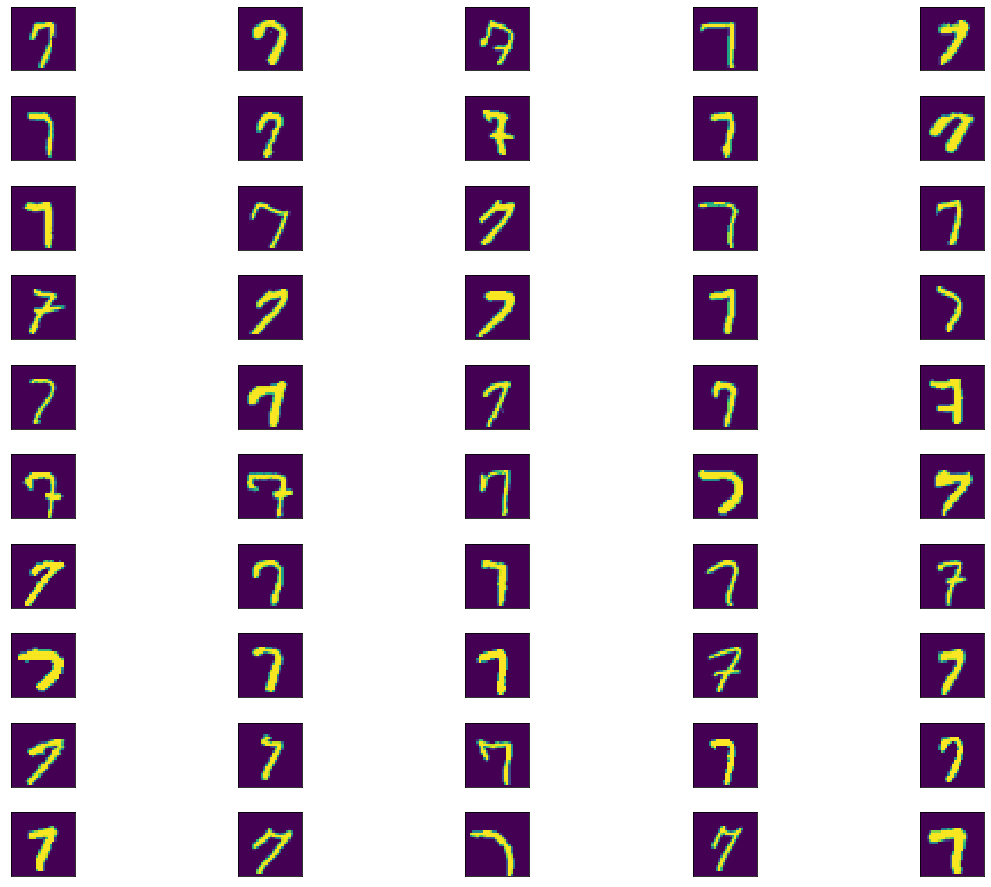

In [11]:
search_image , search_label = get_test_batch()

# 讀取已經存好的手寫數字辨識圖片
retrieval_image = np.load('retrieval_image.npy')

# retrieval_image複製的8000次
retrieval_image = [retrieval_image for _ in range(0 , 8000)]
retrieval_image = np.array(retrieval_image)

# 先計算retrieval_image與search_image分別轉換成的embedding vector
# 再計算兩者所轉換的embedding vector的距離，即為search_distance
# 並取出距離最短的前50名的index，即為top_50
embedding_retrieval , embedding_search = sess.run([embedding_input , embedding_0] , 
                                                  feed_dict = {input_image : retrieval_image , base_image_0 : search_image})
diff_vector = embedding_retrieval - embedding_search
search_distance = (diff_vector[: , 0] ** 2 + diff_vector[: , 1] ** 2) ** 0.5
top_50 = search_distance.argsort()[:50]

fig, ax = plt.subplots(10 , 5 , figsize = (20 , 16))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
for i in range(0 , 10):
    for j in range(0 , 5):
        index = top_50[5 * i + j]
        ax[i , j].imshow(search_image[index , : , : , 0])
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])

outlier檢測 → 從retrieval_image中找出寫得最潦草的

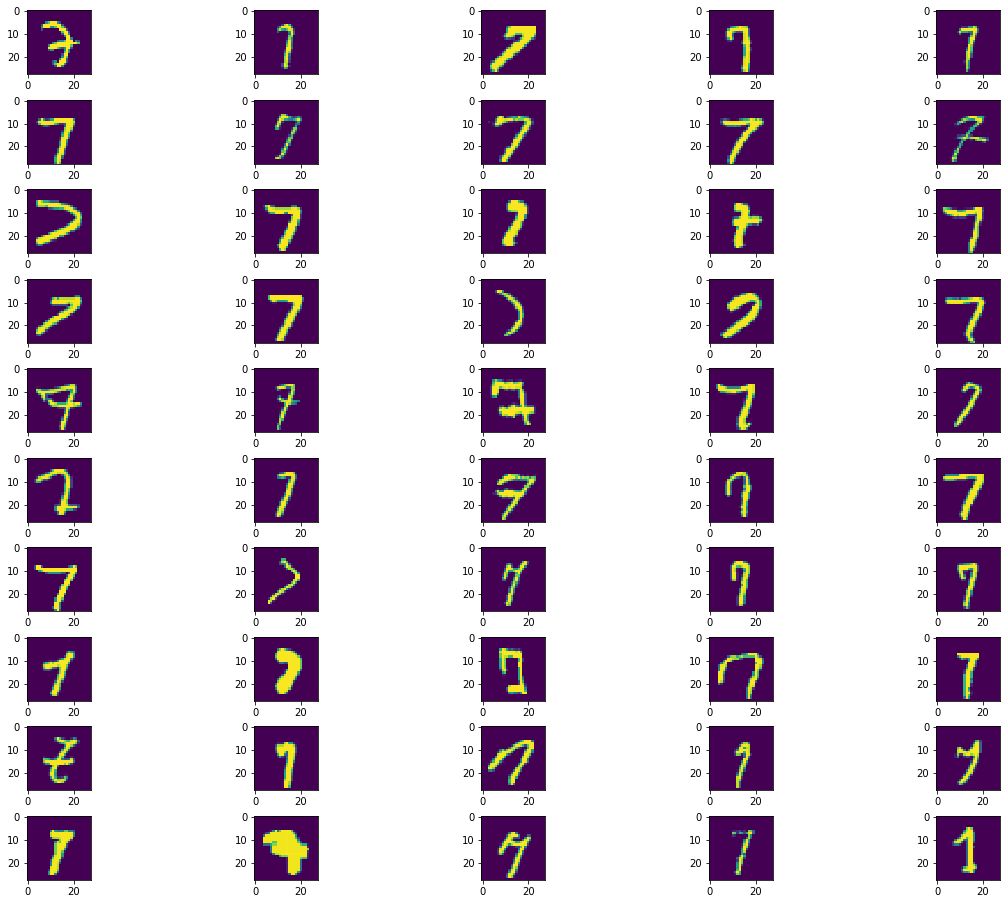

In [12]:
search_image , search_label = get_test_batch()

query_number = 7
index = (search_label == query_number)
retrieval_image = search_image[index]

# 計算retrieval_image所轉換的embedding vector，接著再計算這些embedding vector的平均，即為retrieval_vector_mean
# 接著再將retrieval_vector_mean複製len(retrieval_vector)次
retrieval_vector = sess.run(embedding_input , feed_dict = {input_image : retrieval_image})
retrieval_vector_mean = retrieval_vector.mean(axis = 0)
retrieval_vector_mean = [retrieval_vector_mean for _ in range(0 , len(retrieval_vector))]
retrieval_vector_mean = np.array(retrieval_vector_mean)

# 計算retrieval_vector_mean與retrieval_vector的距離
# 並取出距離最長的前50名的index，即為bottom_50
diff_vector = retrieval_vector_mean - retrieval_vector
search_distance = (diff_vector[: , 0] ** 2 + diff_vector[: , 1] ** 2) ** 0.5
bottom_50 = search_distance.argsort()[-50:]

fig, ax = plt.subplots(10 , 5 , figsize = (20 , 16))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
for i in range(0 , 10):
    for j in range(0 , 5):
        index = bottom_50[5 * i + j]
        ax[i , j].imshow(retrieval_image[index , : , : , 0])